In [1]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

data = pd.read_excel('./data_new.xlsx')

x = data.drop(['price_rate'], axis=1)
x = x.drop(['price'],axis=1)
x = x.drop(['name'],axis=1)
y = data['price']
x

,state,date,wifi,used,capacity,type,price_i
0,C,2020.12,wifi,4.09,128,pro,960000
1,B,2021.01,wifi,0.98,128,pro,1299000
2,C,2021.03,wifi,1.00,256,pro,1429000
3,B,2021.02,lte,2.99,128,normal,720000
4,C,2021.01,lte,6.91,64,mini,710000
...,...,...,...,...,...,...,...
5998,C,2020.11,wifi,8.00,16,mini,420000
5999,C,2021.02,wifi,3.99,128,normal,550000
6000,B,2020.12,wifi,5.03,64,mini,600000
6001,A,2020.11,wifi,0.02,32,normal,449000


In [2]:
import random
import os
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = str(42)

In [3]:
#문자를 숫자로 라벨링
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
#encoder.fit(x['name'])
#x['name']=encoder.transform(x['name'])
encoder.fit(x['state'])
x['state']=encoder.transform(x['state'])
encoder.fit(x['wifi'])
x['wifi']=encoder.transform(x['wifi'])
encoder.fit(x['type'])
x['type']=encoder.transform(x['type'])
x

,state,date,wifi,used,capacity,type,price_i
0,2,2020.12,1,4.09,128,3,960000
1,1,2021.01,1,0.98,128,3,1299000
2,2,2021.03,1,1.00,256,3,1429000
3,1,2021.02,0,2.99,128,2,720000
4,2,2021.01,0,6.91,64,1,710000
...,...,...,...,...,...,...,...
5998,2,2020.11,1,8.00,16,1,420000
5999,2,2021.02,1,3.99,128,2,550000
6000,1,2020.12,1,5.03,64,1,600000
6001,0,2020.11,1,0.02,32,2,449000


In [4]:
#test train 나누기
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.9,test_size=0.1)
x_test
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(5402, 7) (601, 7)
(5402,) (601,)


In [5]:
#기본적인 랜덤 포레스트
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
rf2 = RandomForestRegressor()
rf2.fit(x_train,y_train)
y_predict2 = rf2.predict(x_test)
rmse2 = np.sqrt(mean_squared_error(y_predict2,y_test))
print(rf2.score(x_test,y_test))
print(rmse2)

0.8791060963227557
109166.18219525402


In [6]:
rf = RandomForestRegressor(random_state=0,n_jobs=-1)
kfold = KFold(n_splits=5, shuffle=True) #5개의 그룹으로 나누어줌

parameters={'n_estimators':[50,100,150,200],
            'max_depth' : [6,8,10],
            'min_samples_split' : [2,3,4,5],
            'min_samples_leaf':[1,2,3]}
parameter={}
grid = GridSearchCV(rf,param_grid=parameters,cv=kfold, refit = True)
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=0,
                                             verbose=

In [7]:
score = pd.DataFrame(grid.cv_results_) #결과 추출
print("최적 파라미터:",grid.best_params_)
print("최고점수: ",grid.best_score_)

최적 파라미터: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
최고점수:  0.8827651666007117


In [8]:
#최적 파라미터로 성능 측정
estimator = grid.best_estimator_
pred = estimator.predict(x_test)
mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
print("R-squared: ",estimator.score(x_test,y_test))

RMSE: 104862.24461495563
R-squared:  0.8884508009857133


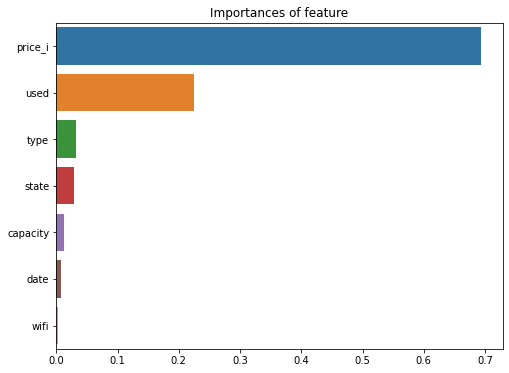

In [9]:
#각 특징의 중요도
import matplotlib.pyplot as plt
import seaborn as sns

importance = estimator.feature_importances_
ftr_importances = pd.Series(importance, index = x_train.columns)
ftr = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Importances of feature')
sns.barplot(x=ftr, y=ftr.index)
plt.show()